- "모든 예시는 아래 블로그를 참고한 것"
- https://data-marketing-bk.tistory.com/entry/Python-COHORT-%EB%B6%84%EC%84%9D-%EA%B0%9C%EB%85%90%EB%B6%80%ED%84%B0-%EC%8B%A4%EC%A0%84-%EC%BD%94%EB%93%9C%EA%B9%8C%EC%A7%80-feat-%EB%B6%84%EC%84%9D-%EC%98%88%EC%A0%9C-%ED%8F%AC%ED%95%A8

# 코호트 분석?
- 비슷한 시기에 비슷한 경험을 한 그룹을 만들어서, 그 그룹의 특징과 행동을 분석하는 방법
    - 예) 같은 달, 같은 서비스를 이용한 고객들을 한 그룹으로 묶고, 이들이 어떻게 서비스를 사용하는지 따져보기

- 특정 기간이나 조건에서 어떤 그룹이 더 좋은 결과를 보이는지 알 수 있다.
- 특정 그룹의 특성을 파악하여, 그룹별로 어떤 영향을 받는지 알아보는 분석 방법

# 코호트 분석 예시
- 목표1: 월별로 소비자들의 재구매율을 판단하여, 2~3달 이내에 가장 많이 이탈한 집단을 발견하기
- 목표2: 소비자 집단 별로 수익성을 판단하여, 어떤 Group의 재방문 및 재구매율을 촉진시켜야 하는지 선정하기

## 0. 데이터 로드

In [187]:
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')


df = pd.read_excel('https://github.com/springcoil/marsmodelling/blob/master/relay-foods.xlsx?raw=true', 
                 sheet_name='Purchase Data - Full Study')

## 1. 데이터 확인
- 컬럼
  - OrderId: 주문 번호
  - OrderDate: 주문 일자
  - UserId: 사용자 ID
  - TotalCharges: 주문 비용
  - CommonId, PupId, PickupDate: 사용X

- shape: (2891, 7)

In [188]:
df.info()

df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2891 entries, 0 to 2890
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   OrderId       2891 non-null   int64         
 1   OrderDate     2891 non-null   datetime64[ns]
 2   UserId        2891 non-null   int64         
 3   TotalCharges  2891 non-null   float64       
 4   CommonId      2891 non-null   object        
 5   PupId         2891 non-null   int64         
 6   PickupDate    2891 non-null   datetime64[ns]
dtypes: datetime64[ns](2), float64(1), int64(3), object(1)
memory usage: 158.2+ KB


,OrderId,OrderDate,UserId,TotalCharges,CommonId,PupId,PickupDate
0,262,2009-01-11,47,50.67,TRQKD,2,2009-01-12
1,278,2009-01-20,47,26.60,4HH2S,3,2009-01-20
2,294,2009-02-03,47,38.71,3TRDC,2,2009-02-04
3,301,2009-02-06,47,53.38,NGAZJ,2,2009-02-09
4,302,2009-02-06,47,14.28,FFYHD,2,2009-02-09


## 2. 데이터 전처리

### 2-1. 필요 없는 column 삭제하기 (CommonId, PupId, PickupDate)

In [189]:
df = df.drop(['CommonId','PupId', 'PickupDate'],axis=1)
df.columns

Index(['OrderId', 'OrderDate', 'UserId', 'TotalCharges'], dtype='object')

### 2-2.구매주기를 월별로 계산할 수 있도록 OrderDate컬럼 변경하기
- 년월일 -> 년월

In [190]:
df['OrderCycle'] = df['OrderDate'].dt.strftime('%Y-%m')
df

,OrderId,OrderDate,UserId,TotalCharges,OrderCycle
0,262,2009-01-11,47,50.6700,2009-01
1,278,2009-01-20,47,26.6000,2009-01
2,294,2009-02-03,47,38.7100,2009-02
3,301,2009-02-06,47,53.3800,2009-02
4,302,2009-02-06,47,14.2800,2009-02
...,...,...,...,...,...
2886,3220,2010-03-08,393616,60.0155,2010-03
2887,3192,2010-03-07,394290,45.4300,2010-03
2888,3193,2010-03-07,394346,14.2100,2010-03
2889,3207,2010-03-08,395039,34.6200,2010-03


## 3. 코호트 분석에 필요한 변수 생성하기

In [191]:
# 유저별로 가장 오래된 구매일 계산 
first_order = df.groupby(['UserId']).min().OrderCycle
first_order

UserId
47        2009-01
95        2009-03
98        2009-01
112       2009-01
141       2009-11
           ...   
393616    2010-03
394290    2010-03
394346    2010-03
395039    2010-03
396551    2010-03
Name: OrderCycle, Length: 757, dtype: object

In [192]:
first_order.name = 'first_order'
first_order

UserId
47        2009-01
95        2009-03
98        2009-01
112       2009-01
141       2009-11
           ...   
393616    2010-03
394290    2010-03
394346    2010-03
395039    2010-03
396551    2010-03
Name: first_order, Length: 757, dtype: object

In [193]:
# first_order를 기존 df에 붙이기
df = pd.merge(df, first_order, left_on='UserId', right_on=first_order.index, how='left')
df

,OrderId,OrderDate,UserId,TotalCharges,OrderCycle,first_order
0,262,2009-01-11,47,50.6700,2009-01,2009-01
1,278,2009-01-20,47,26.6000,2009-01,2009-01
2,294,2009-02-03,47,38.7100,2009-02,2009-01
3,301,2009-02-06,47,53.3800,2009-02,2009-01
4,302,2009-02-06,47,14.2800,2009-02,2009-01
...,...,...,...,...,...,...
2886,3220,2010-03-08,393616,60.0155,2010-03,2010-03
2887,3192,2010-03-07,394290,45.4300,2010-03,2010-03
2888,3193,2010-03-07,394346,14.2100,2010-03,2010-03
2889,3207,2010-03-08,395039,34.6200,2010-03,2010-03


## 4. 월별로 구매 고객 데이터 치환해보기
- 4-1. 주기별 구매한 User 계산
- 4-2. 주기별 구매한 금액 계산
  

### 4-1. 주기별 구매한 User 수 계산

In [194]:
co1 = df.groupby(['first_order','OrderCycle']).UserId.nunique()
co1 = co1.reset_index()
co1.rename({'UserId':'TotalUsers'}, axis=1, inplace=True)
co1

,first_order,OrderCycle,TotalUsers
0,2009-01,2009-01,22
1,2009-01,2009-02,8
2,2009-01,2009-03,10
3,2009-01,2009-04,9
4,2009-01,2009-05,10
...,...,...,...
114,2010-01,2010-02,50
115,2010-01,2010-03,26
116,2010-02,2010-02,100
117,2010-02,2010-03,19


### 4-2. 주기별 구매한 금액 계산

In [195]:
co2 = df.groupby(['first_order','OrderCycle']).TotalCharges.sum()
co2 = co2.reset_index()
co2.rename({'TotalCharges':'PurchaseAmnt'},axis=1, inplace=True)
co2

,first_order,OrderCycle,PurchaseAmnt
0,2009-01,2009-01,1850.2550
1,2009-01,2009-02,1351.0650
2,2009-01,2009-03,1357.3600
3,2009-01,2009-04,1604.5000
4,2009-01,2009-05,1575.6250
...,...,...,...
114,2010-01,2010-02,8453.1039
115,2010-01,2010-03,2238.6461
116,2010-02,2010-02,7374.7108
117,2010-02,2010-03,945.9633


### 4-3. 데이터 병합

In [196]:
co = pd.merge(co1, co2, on=['first_order','OrderCycle'])
co.head()

,first_order,OrderCycle,TotalUsers,PurchaseAmnt
0,2009-01,2009-01,22,1850.255
1,2009-01,2009-02,8,1351.065
2,2009-01,2009-03,10,1357.360
3,2009-01,2009-04,9,1604.500
4,2009-01,2009-05,10,1575.625


In [197]:
co.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 119 entries, 0 to 118
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   first_order   119 non-null    object 
 1   OrderCycle    119 non-null    object 
 2   TotalUsers    119 non-null    int64  
 3   PurchaseAmnt  119 non-null    float64
dtypes: float64(1), int64(1), object(2)
memory usage: 4.6+ KB


## 5. 코호트 기간 기준 계산 및 데이터 형태 최종 완성

### 5-1. 코호트 기간 기준 계산(CohortPeriod)
- 구매월 - 첫 구매월

In [198]:
co_list=[]
for i in range(len(co)):
    f_first_order = pd.to_datetime(co.first_order[i]).to_period('M')
    f_order_cycle = pd.to_datetime(co.OrderCycle[i]).to_period('M')

    month_diff = (f_order_cycle-f_first_order).n
    co_list.append(month_diff)

co['CohortPeriod'] = co_list


In [199]:
co

,first_order,OrderCycle,TotalUsers,PurchaseAmnt,CohortPeriod
0,2009-01,2009-01,22,1850.2550,0
1,2009-01,2009-02,8,1351.0650,1
2,2009-01,2009-03,10,1357.3600,2
3,2009-01,2009-04,9,1604.5000,3
4,2009-01,2009-05,10,1575.6250,4
...,...,...,...,...,...
114,2010-01,2010-02,50,8453.1039,1
115,2010-01,2010-03,26,2238.6461,2
116,2010-02,2010-02,100,7374.7108,0
117,2010-02,2010-03,19,945.9633,1


### 5-2. 코호트 데이터 형태 최종 완성

#### 첫 번째: `재방문율` 계산을 위한 Pandas, Unstack 활용

In [204]:
co_retention = co.set_index(['first_order','CohortPeriod'])

In [201]:
co_retention = co_retention.TotalUsers.unstack(1) # 각 Cohort 별로 기간에 따른 'TotalUsers' 값이 컬럼으로 정리
co_retention

CohortPeriod,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
first_order,,,,,,,,,,,,,,,
2009-01,22.0,8.0,10.0,9.0,10.0,8.0,8.0,7.0,7.0,7.0,7.0,8.0,11.0,7.0,6.0
2009-02,15.0,3.0,5.0,1.0,4.0,4.0,4.0,5.0,5.0,4.0,3.0,3.0,5.0,NaN,NaN
2009-03,13.0,4.0,5.0,4.0,1.0,2.0,2.0,3.0,2.0,1.0,3.0,2.0,1.0,NaN,NaN
2009-04,39.0,13.0,10.0,13.0,6.0,7.0,4.0,6.0,2.0,4.0,3.0,2.0,NaN,NaN,NaN
2009-05,50.0,13.0,12.0,5.0,4.0,6.0,3.0,5.0,5.0,4.0,3.0,NaN,NaN,NaN,NaN
2009-06,32.0,15.0,9.0,6.0,7.0,5.0,3.0,3.0,10.0,3.0,NaN,NaN,NaN,NaN,NaN
2009-07,50.0,23.0,13.0,10.0,11.0,10.0,11.0,7.0,7.0,NaN,NaN,NaN,NaN,NaN,NaN
2009-08,31.0,11.0,9.0,7.0,6.0,8.0,4.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-09,37.0,15.0,14.0,8.0,13.0,9.0,8.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [203]:
retention = co_retention.div(co_retention[0], axis=0)
retention

CohortPeriod,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
first_order,,,,,,,,,,,,,,,
2009-01,1.0,0.363636,0.454545,0.409091,0.454545,0.363636,0.363636,0.318182,0.318182,0.318182,0.318182,0.363636,0.500000,0.318182,0.272727
2009-02,1.0,0.200000,0.333333,0.066667,0.266667,0.266667,0.266667,0.333333,0.333333,0.266667,0.200000,0.200000,0.333333,NaN,NaN
2009-03,1.0,0.307692,0.384615,0.307692,0.076923,0.153846,0.153846,0.230769,0.153846,0.076923,0.230769,0.153846,0.076923,NaN,NaN
2009-04,1.0,0.333333,0.256410,0.333333,0.153846,0.179487,0.102564,0.153846,0.051282,0.102564,0.076923,0.051282,NaN,NaN,NaN
2009-05,1.0,0.260000,0.240000,0.100000,0.080000,0.120000,0.060000,0.100000,0.100000,0.080000,0.060000,NaN,NaN,NaN,NaN
2009-06,1.0,0.468750,0.281250,0.187500,0.218750,0.156250,0.093750,0.093750,0.312500,0.093750,NaN,NaN,NaN,NaN,NaN
2009-07,1.0,0.460000,0.260000,0.200000,0.220000,0.200000,0.220000,0.140000,0.140000,NaN,NaN,NaN,NaN,NaN,NaN
2009-08,1.0,0.354839,0.290323,0.225806,0.193548,0.258065,0.129032,0.129032,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-09,1.0,0.405405,0.378378,0.216216,0.351351,0.243243,0.216216,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### 두 번째: 구매 규모 형태 치환을 위한 Pandas Unstack 활용

In [206]:
co_purchase = co.set_index(['first_order','CohortPeriod'])
co_purchase = co_purchase.PurchaseAmnt.unstack(1)
co_purchase

CohortPeriod,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
first_order,,,,,,,,,,,,,,,
2009-01,1850.2550,1351.0650,1357.3600,1604.5000,1575.6250,1384.8400,1750.8400,1426.5714,1964.2755,860.3292,1821.8153,2152.1165,2084.2236,2068.7771,1504.3325
2009-02,666.3100,501.6100,968.7800,53.3600,758.5200,667.1000,314.1752,567.5057,328.2800,738.9359,263.1971,550.0098,734.7613,NaN,NaN
2009-03,806.3100,463.8000,1108.2100,902.7100,161.2500,1010.8000,1256.4672,1067.9247,905.3610,485.9966,897.1602,642.1517,76.3100,NaN,NaN
2009-04,2561.2500,1189.5800,1085.3800,987.1300,474.0100,531.3825,209.4465,339.1139,147.3250,445.5447,634.6950,279.8733,NaN,NaN,NaN
2009-05,2627.5600,1146.8300,648.2100,381.1500,415.5969,389.0605,351.6800,420.2842,223.5689,613.8222,81.8283,NaN,NaN,NaN,NaN
2009-06,1544.2200,1165.9000,688.2129,922.7762,504.4159,182.9100,295.0000,514.9887,1211.4755,162.1200,NaN,NaN,NaN,NaN,NaN
2009-07,2797.7600,1858.3499,1312.8502,1053.5599,833.4690,506.2409,793.0552,1163.1282,401.7190,NaN,NaN,NaN,NaN,NaN,NaN
2009-08,2605.9981,1869.4376,1313.7691,1228.7399,1723.3975,1213.1379,1595.9906,478.7787,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-09,1953.0553,2433.3013,1953.2262,1371.3499,2262.0346,1842.9434,688.6822,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## 6. 코호트 분석 시각화

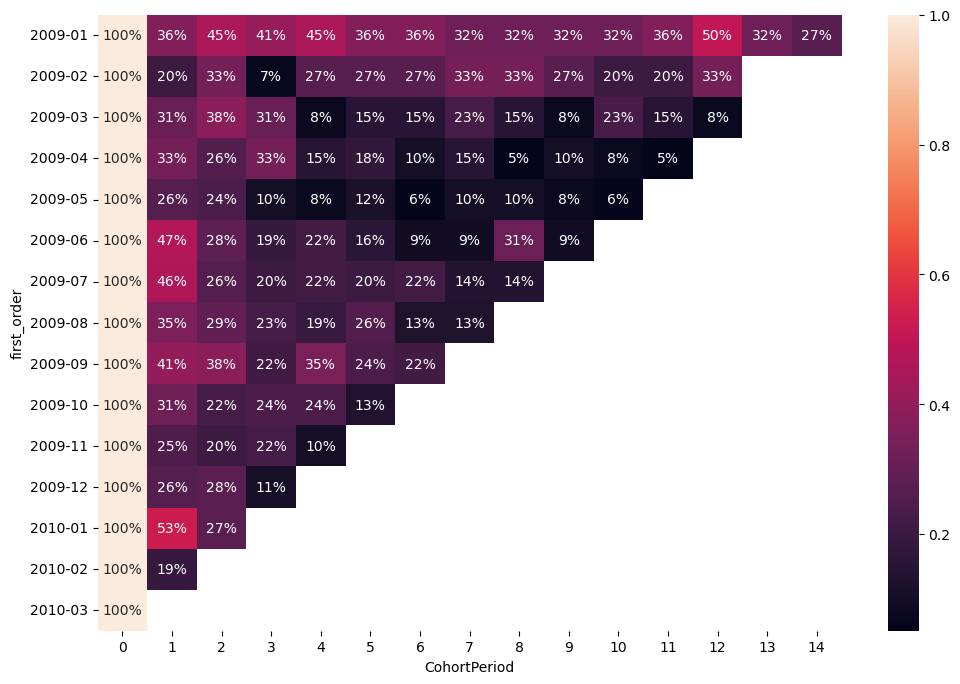

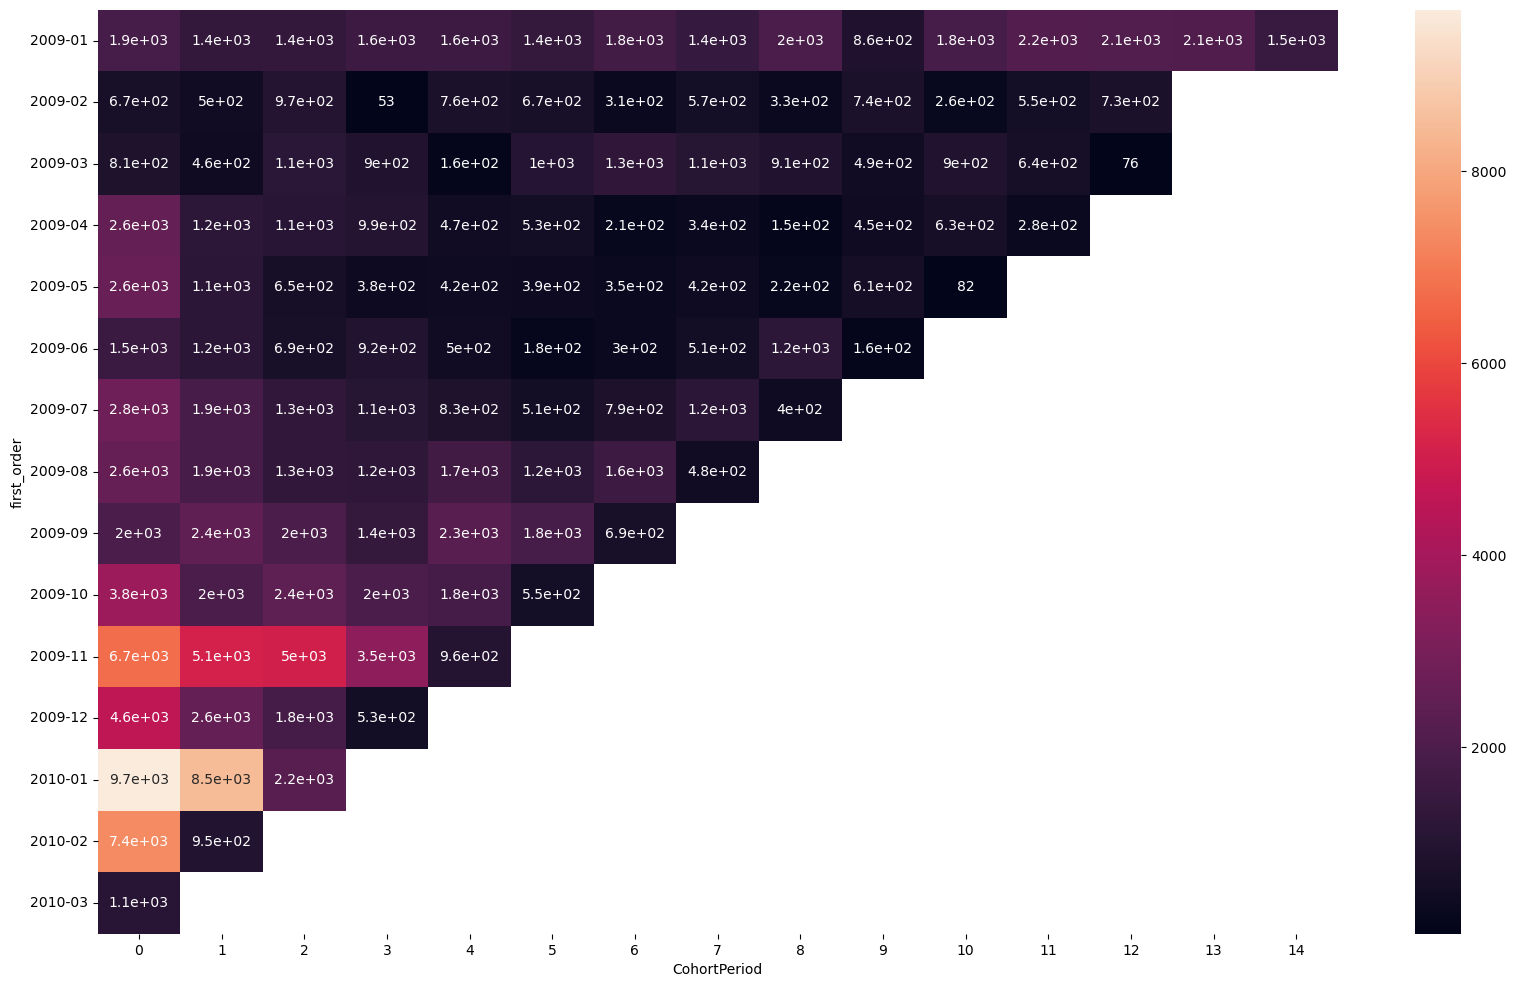

In [217]:
# 재방문율 시각화
plt.rcParams['figure.figsize']=(12,8)
sns.heatmap(retention, annot=True, fmt='.0%')
plt.show()


plt.rcParams['figure.figsize']=(20,12)
sns.heatmap(co_purchase, annot= True)
plt.yticks(rotation=360);

## 7. 코호트 분석 해석
- 목표1: 월별로 소비자들의 재구매율을 판단하여, 2~3달 이내에 가장 많이 이탈한 집단을 발견하기
- 목표2: 소비자 집단 별로 수익성을 판단하여, 어떤 Group의 재방문 및 재구매율을 촉진시켜야 하는지 선정하기

In [225]:
### 목표1: 월별 소비자 집단 중 이탈이 가장 많은 집단 파악
#### 코호트 기간 1에서 살펴보겠다
retention[1].sort_values(ascending=True).head(5)

first_order
2010-02    0.190000
2009-02    0.200000
2009-11    0.246154
2009-05    0.260000
2009-12    0.261538
Name: 1, dtype: float64

In [231]:
### 목표2: 수익성 기반으로 Retention을 재고 해야할 집단 선정
co_purchase[0].sort_values(ascending=False).head(5)

first_order
2010-01    9677.9032
2010-02    7374.7108
2009-11    6738.5869
2009-12    4571.6911
2009-10    3802.2525
Name: 0, dtype: float64

- 위의 두가지 결과를 봤을 때, 2010년 2월/ 2009년 11월/2009년 12월이 눈에 들어온다.
  - 2010년 2월: 수익성은 2순위로 구매력이 높은 집단이다. 그러나 재방문율이 낮아 이탈이 많다고 판단할 수 있다. 따라서 이들의 이탈로 인해 장기적인 수익의 손실이 발생할 수 있다.